## Load Data

In [10]:
import scipy.io as sio
import numpy as  np
import random
import matplotlib.pyplot as plt
%matplotlib inline
data = sio.loadmat('SVHN.mat')

In [11]:
x = data['train_x']
x = np.asarray(x)

y = data['train_label']
y = np.asarray(y)

x.shape

(45000, 784)

In [12]:
def sigmoid(z): return 1.0/(1.0+np.exp(-z))
def sigmoid_prime(z): return sigmoid(z)*(1-sigmoid(z))

In [13]:
def softmax_2(x):

    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

In [14]:
def cross_entropy(x, y):
        return -np.sum(y*np.log(x), axis=1)

In [15]:
def plots(cost_his, words, y_words):
        
        plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
        plt.rcParams['image.interpolation'] = 'nearest'
        plt.rcParams['image.cmap'] = 'gray'
        
        plt.subplot(2, 1, 2)
        plt.plot(cost_his)
        plt.title(words)
        plt.xlabel('Epochs')
        plt.ylabel(y_words)
        plt.show()

## Model

In [16]:
class dnn(object):
    
    # input layer firstinput , others are hidden and weights
    def __init__(self, list_size):
        
        self.layer = len(list_size)
        self.inputsize = list_size[0]
        self.outputsize = list_size[-1]
        self.weights = [ np.random.randn(x,y) for x, y in zip(list_size[:-1], list_size[1:] )] # TRANSPOS
        self.bias = [ np.random.randn(y,) for y in list_size[1:] ]
        self.data_len = 0
        self.cost = 0 #scalar
        self.cost_list = []
        self.error = []
        
        #DEBUG #
        print('========init========')
        print('layer', self.layer)
        print('input', self.inputsize)
        print('output', self.inputsize)
        print('weight matrice', [w.shape for w in self.weights])
        print('bias matrice', [b.shape for b in self.bias])
        print('================')
        #DEBUG #
       
    def truth(self, x, y): #((n,)) softmax  every items -1
        return x-y
    
    def SGD_train(self, training_data, labels_data, epoches, mini_size,learning_rate, lamda): # 
        
        #DEBUG #
        self.data_len = len(training_data)
        
        print('=======train=========')
        print('data len:', self.data_len)
        print('len train:', len(training_data), 'labes:', len(labels_data), 'ep', epoches)
        print('min', mini_size, 'learn', learning_rate, 'lambda', lamda)
        print('================')
         #DEBUG #
        
        for i in range(epoches):   # epoches = steps
            
            print('epoches:', i)
            shuffle = np.random.choice(self.data_len, self.data_len)
            x_shuffle = training_data[shuffle]
            y_shuffle = labels_data[shuffle]
           
            begin = 0
            total_size = 0
            
            #plot
            total_correct = 0
            cross_cost = 0

            while(total_size < self.data_len):

                total_size += mini_size
                
                x_batch, y_batch = training_data[begin: total_size], labels_data[begin: total_size]
                
                cross_cost+= self.update_bw(x_batch, y_batch, learning_rate, lamda, self.data_len )
                
                begin+=mini_size
            
            #cross_cost
            cross_avg = cross_cost/self.data_len 
            print('entropy cost:', cross_avg)
            self.cost_list.append(cross_avg)
            
            #missclassification
            all_activ = []
            all_y = []
            activations, zlist = self.foward(training_data)
            all_activ.append(activations[-1])
            all_y.append(labels_data)
            
            for i in range(self.data_len):
                if(np.argmax(all_activ[0][i]) == np.argmax(all_y[0][i])):
                    total_correct +=1
            
            missclass = (self.data_len - total_correct)/ self.data_len
            print('missclass:', missclass)
            self.error.append(missclass) 
            
    def update_bw(self, x_data, y_data, learning_rate, lamda, N): # learning rate ,lamda
        
        batches_len = len(x_data)
        mini_cost = 0
        
        new_weights = [np.zeros(w.shape) for w in self.weights] # zeroes
        new_bias = [np.zeros(b.shape) for b in self.bias] #initaial
       
        activations, zlist = self.foward(x_data)
        #print('a:', [a.shape for a in activations])
        mini_cost = self.cross_entropy(activations[-1], y_data)
        
        
        self.backward(y_data, learning_rate, activations, zlist)
        
        
        return np.sum(mini_cost)

    def foward(self, a): #(bactches,784)
        
        activations = []
        z_list = []
        activations.append(a) # a[0] = inputs
        
        i = 1 # first dot weight
        
        for w, b in zip(self.weights, self.bias): # 
            
            z = a.dot(w)+b
            z_list.append(z)
            
            #softmax if 3 -> w = n-1 = 2 , final layer(output) is softmax
            if i == len(self.weights):
                a = self.softmax_2(z)
    
            else:
                a = sigmoid(z) # all count is z

            i+=1
            
            activations.append(a)

        return (activations, z_list)
        
    
    def backward(self, y_batch, learning_rate, activations, z_list):
        
        delta_bias = [np.zeros(b.shape) for b in self.bias]
        delta_weights = [np.zeros(w.shape) for w in self.weights]
        delta = self.truth(activations[-1], y_batch)
       
        delta_bias[-1] = delta
        delta_weights[-1] = activations[-2].transpose().dot(delta) # dw[-1]: a[-2].T* delta
       
        for j in range(2, self.layer): # exclude self

            z = z_list[-j] #  z[-2] last 2
            sigmoid_de = sigmoid_prime(z)
    
            u = delta.dot(self.weights[-j+1].transpose()) # w[-1].T *delta ; delta is truth,a[-1] , the w[-2]
        
            delta = u*sigmoid_de

            delta_bias[-j] = delta # db[-2] = delta

            delta_weights[-j] =  activations[-j-1].transpose().dot(delta) # dw[-2] = a[-3].T*delta'''

        self.weights = [ w -learning_rate*dw for w, dw in zip(self.weights, delta_weights)] 
        self.biases = [b - learning_rate*db for b, db in zip(self.bias, delta_bias)]
            
    def softmax_2(self, x):
        
        probs = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs
   
    def cross_entropy(self, x, y):
        return -np.sum(y*np.log(x), axis=1)

In [20]:
network = dnn( [784,100, 10]) # anylayer to try , inputlayer :784 , outputlayer :10

========init========
layer 3
input 784
output 784
weight matrice [(784, 100), (100, 10)]
bias matrice [(100,), (10,)]


In [21]:
network.SGD_train(x, y,300, 100, 0.01, 0.05)  #((self, training_data, labels_data, epoches, mini_size,learning_rate, lamda)

=======train=========
data len: 45000
len train: 45000 labes: 45000 ep 300
min 100 learn 0.01 lambda 0.05
epoches: 0
entropy cost: 5.35919830151
missclass: 0.8798
epoches: 1
entropy cost: 3.36039748501
missclass: 0.8145555555555556
epoches: 2
entropy cost: 2.69170643881
missclass: 0.7710222222222223
epoches: 3
entropy cost: 2.44660349366
missclass: 0.7278666666666667
epoches: 4
entropy cost: 2.3116534961
missclass: 0.6688
epoches: 5
entropy cost: 2.14027426503
missclass: 0.6741555555555555
epoches: 6
entropy cost: 2.04756516936
missclass: 0.6467777777777778
epoches: 7
entropy cost: 1.96401270514
missclass: 0.6186666666666667
epoches: 8
entropy cost: 1.88075962659
missclass: 0.6082666666666666
epoches: 9
entropy cost: 1.80702693288
missclass: 0.5570888888888889
epoches: 10
entropy cost: 1.76203411112
missclass: 0.5867555555555556
epoches: 11
entropy cost: 1.71046974247
missclass: 0.5334222222222222
epoches: 12
entropy cost: 1.66391750792
missclass: 0.514
epoches: 13
entropy cost: 1.6296

## Plots

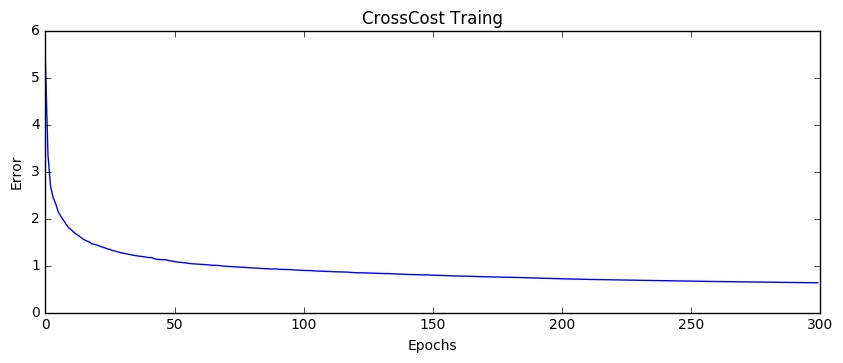

In [22]:
plots(network.cost_list, 'CrossCost Traing', 'Error')

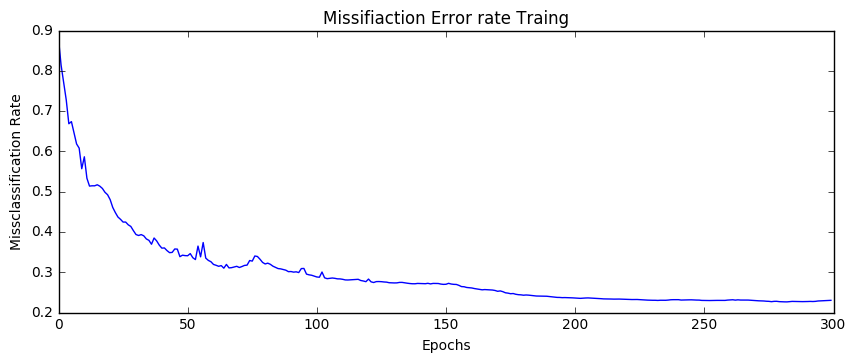

In [23]:
plots(network.error, 'Missifiaction Error rate Traing', 'Missclassification Rate')

## Trainging Classfication 

In [24]:
a, z = network.foward(x)
a = a[-1]
total=0
print(len(a))
for i in range(len(x)):
    if np.argmax(a[i]) == np.argmax(y[i]):
        total+=1

print('correct number', total)

45000
correct number 34640


## Testing Classfication 

In [25]:
y_test = data['test_label']
x_test = data['test_x']
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
a, z = network.foward(x_test)
a = a[-1]
total=0
print(len(a))
for i in range(len(x_test)):
    if np.argmax(a[i]) == np.argmax(y_test[i]):
        total+=1

print('acc total', total)
print('Testing  error classification rate',(len(a)-total)/len(a))
print("testing cross entropy", np.sum(cross_entropy(a[-1], y_test))/len(x))

15000
acc total 10117
Testing  error classification rate 0.32553333333333334
testing cross entropy 1.89263079179


## Reference

http://cs231n.stanford.edu

https://github.com/mnielsen/neural-networks-and-deep-learning